In [1]:
import os

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
import jax.numpy as jnp
import equinox as eqx
import jax.tree_util as jtu
import numpyro

from numpyro.infer import SVI, Trace_ELBO, Predictive
from copy import deepcopy
from math import prod
from jax import random, nn, vmap, devices, device_put

from bmr4pml.models import SVIRegression, BMRRegression
from bmr4pml.nn import MLP, LeNet
from bmr4pml.datasets import load_data
from bmr4pml.inference import fit_and_test

rng_key = random.PRNGKey(0)

In [4]:
def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def run_inference(rng_key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression):

    reg = reg_model(
        nnet,
        **opts_regression
    )

    rng_key, opts_fitting['key'] = random.split(rng_key)
    return fit_and_test(reg, train_ds, test_ds, opts_fitting)

def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.95, 1.])
    fig.tight_layout()

    return fig

In [5]:
from numpyro.optim import _NumPyroOptim
import optax

class VadamToNumpyro(object):

    def __call__(self, transformation) -> _NumPyroOptim:
        """
        This function produces a ``numpyro.optim._NumPyroOptim`` instance from an
        ``optax.GradientTransformation`` so that it can be used with
        ``numpyro.infer.svi.SVI``. It is a lightweight wrapper that recreates the
        ``(init_fn, update_fn, get_params_fn)`` interface defined by
        :mod:`jax.example_libraries.optimizers`.

        :param transformation: An ``optax.GradientTransformation`` instance to wrap.
        :return: An instance of ``numpyro.optim._NumPyroOptim`` wrapping the supplied
            Optax optimizer.
        """

        def init_fn(params):
            opt_state = transformation.init(params)
            return params, opt_state

        def update_fn(step, grads, state):
            params, opt_state = state
            updates, opt_state = transformation.update(grads, opt_state, params)
            updated_params = optax.apply_updates(params, updates)
            return updated_params, opt_state

        def get_params_fn(state):
            params, opt_state = state
            return jtu.tree_map(lambda x, e: x + e, params, opt_state[0].ε)

        return _NumPyroOptim(lambda x, y, z: (x, y, z), init_fn, update_fn, get_params_fn)

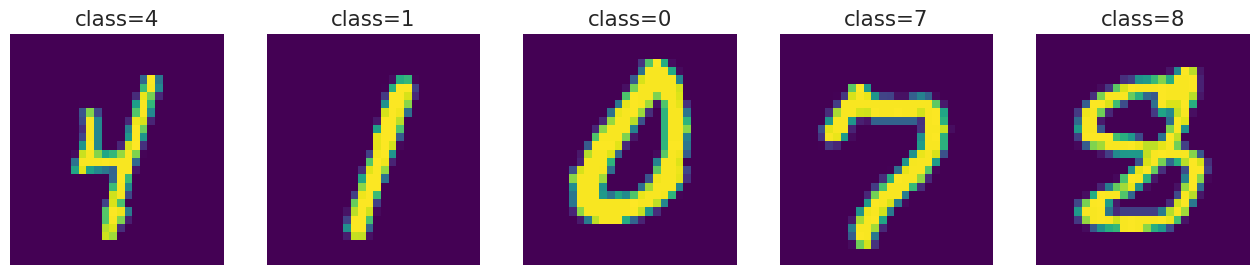

In [6]:
# load data
train_ds, test_ds = load_data('mnist', id=0)

in_size = train_ds['image'].shape[-3:]
out_size = len(jnp.unique(train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    sns.heatmap(
        train_ds['image'][n].squeeze() / 255, 
        cmap='viridis', 
        ax = axes[n], 
        cbar=False, 
        vmax=1., 
        vmin=0.,
        xticklabels="",
        yticklabels=""
    )
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

train_ds['image'], test_ds['image'] = standardize(train_ds['image'], test_ds['image'], num_channels=1)

In [55]:
import numpyro.distributions as dist

def init_fn(rng_key, shape, radius=2.):
    return random.uniform(rng_key, shape=shape, minval=-radius, maxval=radius)

def get_linear_layers(nnet):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear) or isinstance(x, eqx.nn.Conv) or isinstance(x, eqx.nn.LayerNorm)
    return [x for x in jtu.tree_leaves(nnet, is_leaf=is_linear) if is_linear(x)]

def register_network_params(nnet, mask, adaptive_scale=True):
    layers = get_linear_layers(nnet)
    L = len(layers)
    new_layers = []
    for l, layer in enumerate(layers):
        name = f'layer{l}'
        weight = layer.weight
        bias = layer.bias
        shape = weight.reshape(weight.shape[0], -1).shape
        if bias is not None:
            shape = (shape[0], shape[1] + 1)
        
        _scale = numpyro.param(f'{name}._scale', lambda key: init_fn(key, (1,), radius=1)) if adaptive_scale else 0.5

        if l == L - 1:
            scale = jnp.exp( - 0.32 * _scale + 0.65)
        else:
            scale = jnp.exp( - 0.32 * _scale + 0.65) / 10

        _weights = scale * numpyro.param(name, lambda key: init_fn(key, shape))

        _weights = jnp.where(mask[name], _weights, 0.) if mask is not None else _weights
        
        weight = _weights.reshape(weight.shape) if bias is None else _weights[..., :-1].reshape(weight.shape)
        bias = _weights[..., -1].reshape(bias.shape) if bias is not None else bias

        layer = eqx.tree_at(lambda x: (x.weight, x.bias), layer, (weight, bias))
        new_layers.append(layer)
    
    return eqx.tree_at(get_linear_layers, nnet, new_layers)

def likelihood(nnet, x, y, batch_size=None):
    N = x.shape[0]
    with numpyro.plate('data', N, subsample_size=batch_size):
        batch_x = numpyro.subsample(x, event_dim=3)
        key = random.PRNGKey(0) if numpyro.prng_key() is None else numpyro.prng_key()
        keys = random.split(key, batch_x.shape[0]) 
        logits = numpyro.deterministic('logits', vmap(nnet)(batch_x, key=keys) )

        batch_y = y if y is None else numpyro.subsample(y, event_dim=0)
        
        numpyro.deterministic('probs', nn.softmax(logits, -1))
        with numpyro.handlers.scale(scale=1/N):
            numpyro.sample('obs', dist.Categorical(logits=logits), obs=batch_y)

def model(nnet, x, y=None, batch_size=None, mask=None, adaptive_scale=True):

    nnet = register_network_params(nnet, mask, adaptive_scale=adaptive_scale)
    likelihood(nnet, x, y, batch_size)

def guide(*args, **kwargs):
    pass

In [8]:
from bmr4pml.inference import tests
from functools import partial

loss = Trace_ELBO()

def train_and_test(optim, rng_key, num_epochs, num_iters, test_ds, *args, t_lam=None, N=1, prune=False, del_f=None, progress_bar=False, **kwargs):
    svi = SVI(model, guide, optim, loss)
    rng_key, key = random.split(rng_key)
    state = svi.init(key, *args, **kwargs)
    params = svi.get_params(state)
    mask = jtu.tree_map(lambda x: True, params)

    losses = []
    results = {'acc': [], 'ece': [], 'nll': [], 'lpd': []}
    det_nnet = eqx.tree_inference(args[0], value=True)

    for epoch in range(num_epochs):
        key, _key = random.split(key)
        kwargs = kwargs | {'mask': mask}
        svi_out = svi.run(
            _key, 
            num_iters,
            *args,
            progress_bar=progress_bar,
            init_state=state,
            init_params=params,
            ** kwargs 
        )

        state = svi_out.state
        params = svi_out.params
        losses.append( svi_out.losses )

        mdl = partial(numpyro.handlers.substitute(model, params), det_nnet, mask=mask)

        key, _key = random.split(key)
        smpl = Predictive(mdl, num_samples=1)(_key, test_ds['image'], y=test_ds['label'])
        smpl.pop('obs')
        
        output = tests(mdl, smpl, test_ds['image'], test_ds['label'])
        for label in results:
            results[label].append(output[label])
        
        if prune and epoch < num_epochs - 1:
            sigmas = jtu.tree_map( lambda x: 1 / jnp.sqrt( N * (x + t_lam) ), state.optim_state[1][1][0].s)
            mu = params
            mask = jtu.tree_map(lambda m, s, t: t * (del_f(m, s) <= 0), mu, sigmas, mask)

    results['losses'] = losses
    results['mask'] = mask

    return results, rng_key, params, state

# DenseNet

In [6]:
depth = 3
num_neurons = 100
num_epochs = 20
num_iters = 500

cpu = devices('cpu')[0]
results = {'dense': {}, 'lenet': {}}

In [7]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 128, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
nnet = MLP( prod(in_size), out_size, num_neurons, depth, activation=nn.swish, dropout_rate=0.2, key=key)

100%|██████████| 10/10 [00:31<00:00,  3.15s/it, init loss: 240071.4688, avg. loss [epoch 10]: 101200.2500]


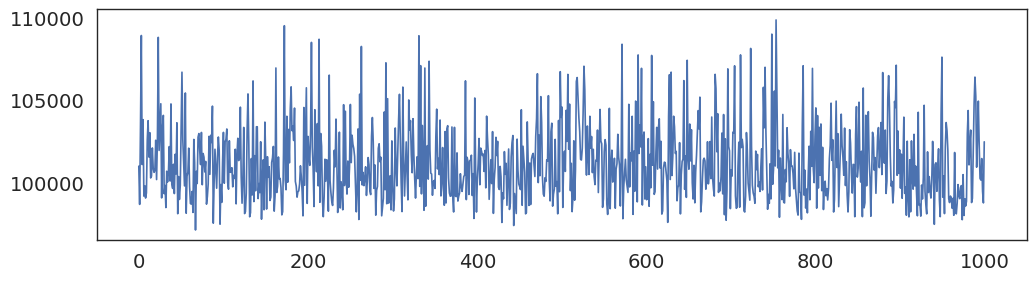

In [41]:
rng_key, key = random.split(rng_key)
output = run_inference(key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 10/10 [01:51<00:00, 11.14s/it, init loss: 1914202.1250, avg. loss [epoch 10]: 23461.3848]


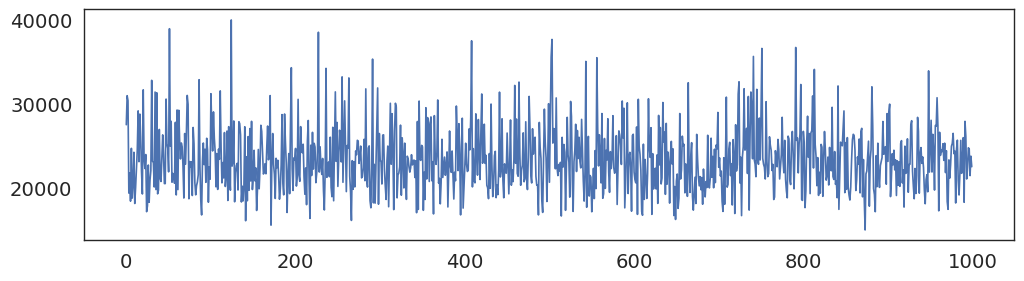

In [42]:
opts_regression = opts_regression | {'autoguide': 'mean-field'}
opts_fitting = opts_fitting | {'num_samples': 100}

dense = eqx.tree_inference(nnet, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 10/10 [03:16<00:00, 19.67s/it, init loss: 431053.4688, avg. loss [epoch 10]: 18874.5293]


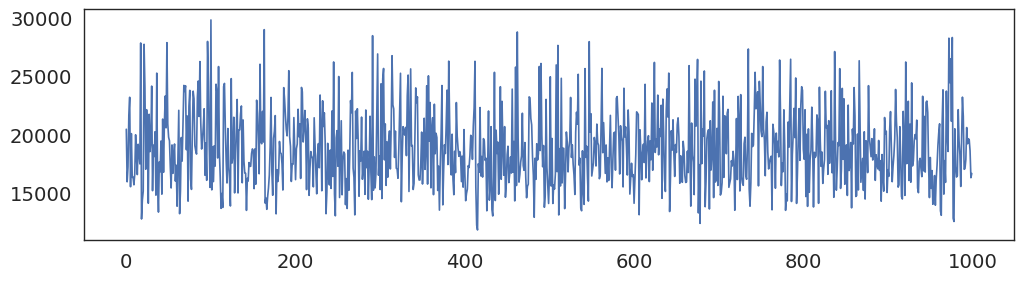

In [43]:
opts_regression = opts_regression | {'tau0': 1e-2, 'reduced': True, 'autoguide': 'mean-field'}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 128, 'with_hyperprior': True}}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Tiered-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [50]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'pruning': 'spike-and-slab',
    'posterior': 'normal',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': max(500, num_iters - 10_000),
    'num_samples': 100,
    'model_kwargs': {
        'batch_size': 128, 
        'with_hyperprior': False,
    }
}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
state, params = run_inference(key, dense, opts_regression, opts_fitting | {'warmup_iters': 5_000}, train_ds, test_ds, reg_model=BMRRegression)

100%|██████████| 10/10 [01:31<00:00,  9.13s/it, init loss: 22088.2305, avg. loss [epoch 10]: 14630.3994]


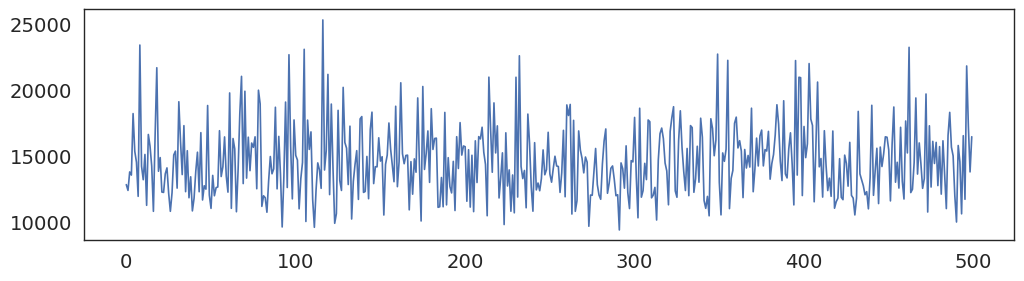

In [51]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'pruning': 'spike-and-slab'}

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['dense']['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

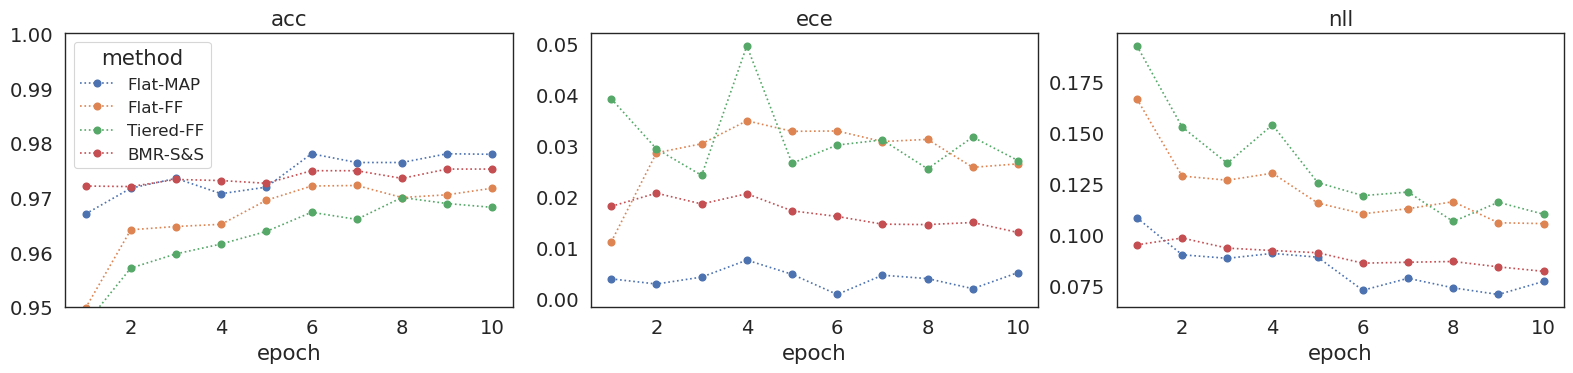

In [52]:
plot_performance( results['dense'], num_epochs );

### Vadam

In [56]:
from optim import vadam, vadabelief

N = train_ds['image'].shape[0]
t_lam = 1 / N
t_init = 100 / N
learning_rate = 1e-2
loss = Trace_ELBO()

rng_key, key = random.split(rng_key)
_vadam_to_numpyro = VadamToNumpyro()
optimizer1 = _vadam_to_numpyro( vadam(key=key, learning_rate=learning_rate, t_lam=t_lam, t_init=t_init, N=N) )
optimizer2 = _vadam_to_numpyro( vadabelief(key=key, learning_rate=learning_rate, t_lam=t_lam, t_init=t_init, N=N) )

In [57]:
def del_f(mu, sigma, sigma0=1.):
    return jnp.log(sigma0/sigma) - 0.5 * mu ** 2 / sigma ** 2

Df = partial(del_f, sigma0=jnp.sqrt(1/(t_lam * N)))

In [27]:
from numpyro.optim import optax_to_numpyro

optimizer3 = optax_to_numpyro( optax.adam(learning_rate=learning_rate) )
optimizer4 = optax_to_numpyro( optax.adamw(learning_rate=learning_rate) )
optimizer5 = optax_to_numpyro( optax.adabelief(learning_rate=learning_rate) )
optimizer6 = optax_to_numpyro( optax.lion(learning_rate=learning_rate / 10) )

In [ ]:
num_epochs = 30
batch_size = 128
num_iters = 500
kwargs = {
    'y': train_ds['label'],
    'batch_size': batch_size
}

args1 = (nnet, train_ds['image'])

det_nnet = eqx.tree_inference(nnet, value=True)
args2 = (det_nnet, train_ds['image'])

results_all = {}

In [31]:
results_all['adam'] = train_and_test(optimizer3, rng_key, num_epochs, num_iters, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:02<00:00, 199.03it/s, init loss: 0.0849, avg. loss [476-500]: 0.2418]


In [32]:
results_all['adamw'] = train_and_test(optimizer4, rng_key, num_epochs, num_iters, *args2, progress_bar=True, **kwargs);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:02<00:00, 198.89it/s, init loss: 0.1526, avg. loss [476-500]: 0.2452]


In [33]:
results_all['adabelief'] = train_and_test(optimizer5, rng_key, num_epochs, num_iters, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:02<00:00, 185.64it/s, init loss: 0.0930, avg. loss [476-500]: 0.1623]


In [34]:
results_all['lion'] = train_and_test(optimizer6, rng_key, num_epochs, num_iters, *args2, progress_bar=True, **kwargs);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:02<00:00, 198.16it/s, init loss: 0.0063, avg. loss [476-500]: 0.0693]


In [35]:
results_all['vadam'] = train_and_test(optimizer1, rng_key, num_epochs, num_iters, *args2, progress_bar=True, **kwargs);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:03<00:00, 160.54it/s, init loss: 0.0739, avg. loss [476-500]: 0.3748]


In [77]:
results_all['vadabelief'] = train_and_test(optimizer2, rng_key, num_epochs, num_iters, *args, **kwargs);

In [36]:
results_all['bmr-vadam'] = train_and_test(
    optimizer1, rng_key, num_epochs, num_iters, *args2, t_lam=t_lam, prune=True, del_f=Df, progress_bar=True, **kwargs
);
print(jtu.tree_map(lambda m: m.mean(), results_all['bmr-vadam'][0]['mask']))


100%|██████████| 500/500 [00:03<00:00, 160.23it/s, init loss: 0.3636, avg. loss [476-500]: 0.4026]


{'layer0': Array(0.67421657, dtype=float32), 'layer0._scale': Array(1., dtype=float32), 'layer1': Array(0.7666336, dtype=float32), 'layer1._scale': Array(1., dtype=float32), 'layer2': Array(0.76168317, dtype=float32), 'layer2._scale': Array(1., dtype=float32), 'layer3': Array(0.85643566, dtype=float32), 'layer3._scale': Array(1., dtype=float32)}


In [ ]:
results_all['bmr-vadabelief'] = train_and_test(
    optimizer2, rng_key, num_epochs, num_iters, *args2, t_lam=t_lam, prune=True, del_f=Df, **kwargs
);
print(jtu.tree_map(lambda m: m.mean(), results_all['bmr-vadabelief'][0]['mask']))

(0.8, 0.92)

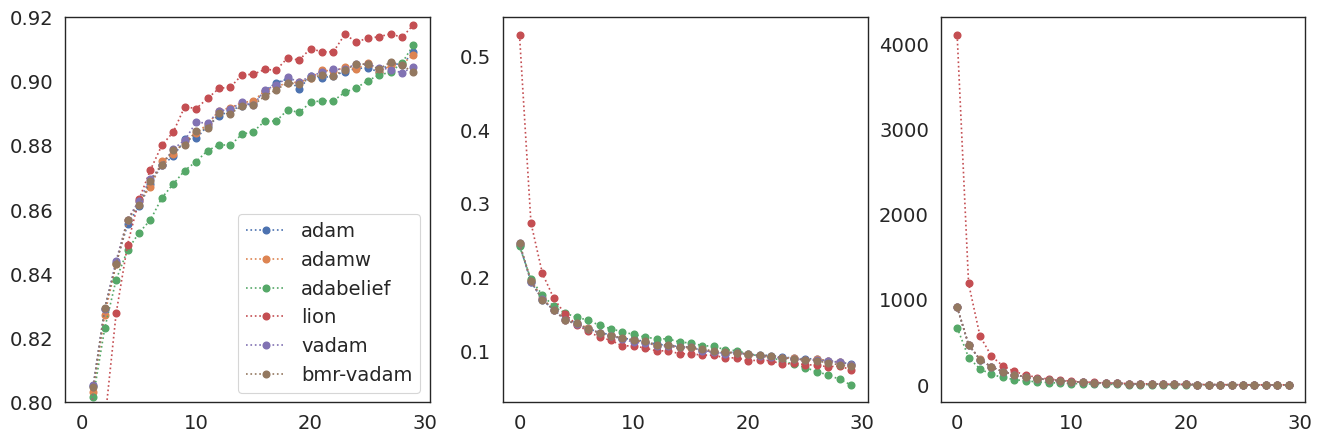

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for method in results_all:
    axes[0].plot(results_all[method][0]['acc'], 'o:', label=method)
    axes[1].plot(results_all[method][0]['ece'], 'o:')
    axes[2].plot(results_all[method][0]['nll'], 'o:')

axes[0].legend()
axes[0].set_ylim([.8, .92])

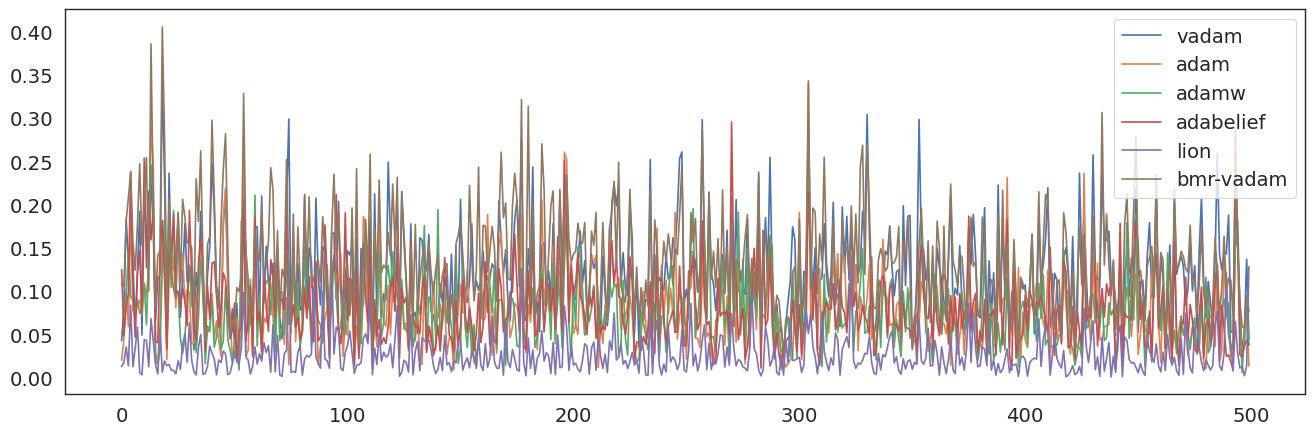

In [27]:
plt.figure(figsize=(16, 5))
for method in results_all:
    plt.plot( results_all[method][0]['losses'][-1], label=method)

plt.legend()

## LeNet

In [9]:
train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

rng_key, key = random.split(rng_key)
lenet = LeNet(in_size, activation=nn.tanh, dropout_rate=0.5, key=key)

(1, 32, 32)


In [17]:
num_epochs = 10
num_iters = 500
batch_size = 128


opts_regression = {
    'regtype': 'multinomial',
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-3
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': batch_size, 
        'with_hyperprior': False
    }
}

results = {'lenet': {}, 'mlp': {}}

In [15]:
rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-MAP'] = output

100%|██████████| 10/10 [05:11<00:00, 31.17s/it, init loss: 237395.6719, avg. loss [epoch 10]: 62604.8828]


100%|██████████| 10/10 [06:08<00:00, 36.83s/it, init loss: 1269205.7500, avg. loss [epoch 10]: 38370.5195]


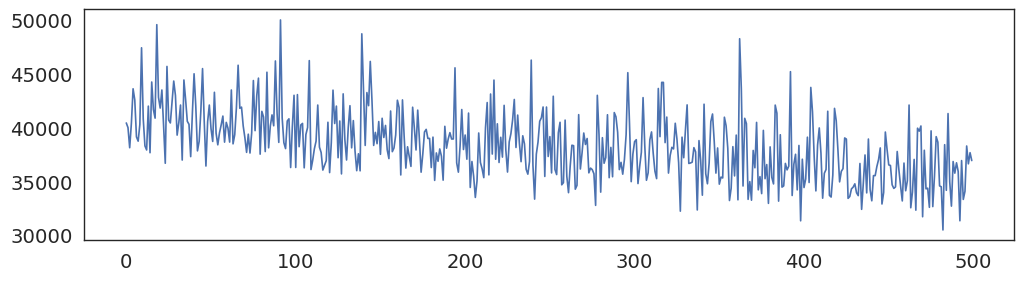

In [16]:
opts_regression = opts_regression | {'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 5 * 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100}

det_lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, det_lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Flat-FF'] = output

plt.figure( figsize=(12, 3) )
plt.plot( output['losses'][-1] )

In [18]:
opts_regression = opts_regression | {'tau0': 1e-2, 'reduced': True, 'autoguide': 'mean-field', 'optim_kwargs': {'learning_rate': 5 * 1e-3}}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': batch_size, 'with_hyperprior': True}}

lenet = eqx.tree_inference(lenet, value=True)

output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['lenet']['Tiered-FF'] = output

100%|██████████| 10/10 [07:32<00:00, 45.29s/it, init loss: 302311.5312, avg. loss [epoch 10]: 17244.6699]


In [19]:
opts_regression = {
    'regtype': 'multinomial',
    'pruning': 'spike-and-slab',
    'posterior': 'normal',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 100,
    'model_kwargs': {
        'batch_size': batch_size, 
        'with_hyperprior': False,
    }
}

lenet = eqx.tree_inference(lenet, value=True)

rng_key, key = random.split(rng_key)
state, params = run_inference(key, lenet, opts_regression, opts_fitting | {'warmup_iters': num_iters}, train_ds, test_ds, reg_model=BMRRegression)

In [21]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'pruning': 'spike-and-slab'}

rng_key, key = random.split(rng_key)
output = run_inference(key, lenet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['lenet']['BMR-S&S'] = output

100%|██████████| 10/10 [06:30<00:00, 39.02s/it, init loss: 100342.7031, avg. loss [epoch 10]: 14532.3662]


(0.7, 0.99)

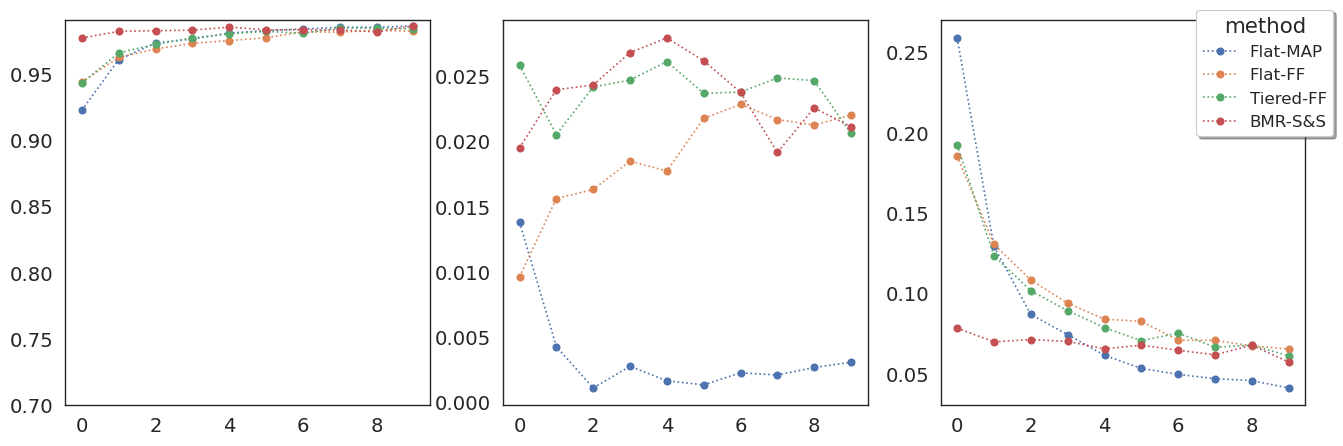

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for method in results['lenet']:
    axes[0].plot(results['lenet'][method]['acc'], 'o:')
    axes[1].plot(results['lenet'][method]['ece'], 'o:')
    axes[2].plot(results['lenet'][method]['nll'], 'o:', label=method)


axes[-1].legend(bbox_to_anchor=(1.1, 1.05), fancybox=True, shadow=True, title='method', fontsize=12)
axes[0].set_ylim([.7, .99])

In [23]:
num_epochs = 10
batch_size = 128
num_iters = 500
kwargs = {
    'y': train_ds['label'],
    'batch_size': batch_size
}

args1 = (lenet, train_ds['image'])

det_lenet = eqx.tree_inference(lenet, value=True)
args2 = (det_lenet, train_ds['image'])

results_all = {}

In [61]:
results_all['adam'] = train_and_test(optimizer3, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 145.81it/s, init loss: 0.0242, avg. loss [476-500]: 0.0231]


In [62]:
results_all['adamw'] = train_and_test(optimizer4, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:03<00:00, 144.22it/s, init loss: 0.0156, avg. loss [476-500]: 0.0245]


In [63]:
results_all['adabelief'] = train_and_test(optimizer5, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 146.25it/s, init loss: 0.0281, avg. loss [476-500]: 0.0250]


In [64]:
results_all['lion'] = train_and_test(optimizer6, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:03<00:00, 147.81it/s, init loss: 0.0391, avg. loss [476-500]: 0.0133]


In [58]:
results_all['vadam'] = train_and_test(optimizer1, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 125.83it/s, init loss: 0.3430, avg. loss [476-500]: 0.2497]


In [59]:
results_all['vadam-bmr'] = train_and_test(
    optimizer1, rng_key, num_epochs, num_iters, test_ds, *args2, t_lam=t_lam, prune=True, del_f=Df, progress_bar=True, **kwargs
);
print(jtu.tree_map(lambda m: m.mean(), results_all['vadam-bmr'][0]['mask']))

100%|██████████| 500/500 [00:03<00:00, 128.23it/s, init loss: 0.3430, avg. loss [476-500]: 0.2497]


{'layer0': Array(1., dtype=float32), 'layer0._scale': Array(1., dtype=float32), 'layer1': Array(1., dtype=float32), 'layer1._scale': Array(1., dtype=float32), 'layer2': Array(0.99999994, dtype=float32), 'layer2._scale': Array(1., dtype=float32), 'layer3': Array(1., dtype=float32), 'layer3._scale': Array(1., dtype=float32), 'layer4': Array(0.99999994, dtype=float32), 'layer4._scale': Array(1., dtype=float32)}


In [39]:
results_all['vadabelief'] = train_and_test(optimizer2, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 126.86it/s, init loss: 0.4031, avg. loss [476-500]: 0.2917]


In [40]:
results_all['vadabelief-bmr'] = train_and_test(
    optimizer2, rng_key, num_epochs, num_iters, test_ds, *args2, t_lam=t_lam, prune=True, del_f=Df, progress_bar=True, **kwargs
);
print(jtu.tree_map(lambda m: m.mean(), results_all['vadabelief-bmr'][0]['mask']))

100%|██████████| 500/500 [00:03<00:00, 125.91it/s, init loss: 0.2996, avg. loss [476-500]: 0.2757]


{'layer0': Array(0.6923077, dtype=float32), 'layer0._scale': Array(0., dtype=float32), 'layer1': Array(0.4321192, dtype=float32), 'layer1._scale': Array(0., dtype=float32), 'layer2': Array(0.38877803, dtype=float32), 'layer2._scale': Array(0., dtype=float32), 'layer3': Array(0.38921684, dtype=float32), 'layer3._scale': Array(1., dtype=float32), 'layer4': Array(0.43294117, dtype=float32), 'layer4._scale': Array(1., dtype=float32)}


(0.9, 0.99)

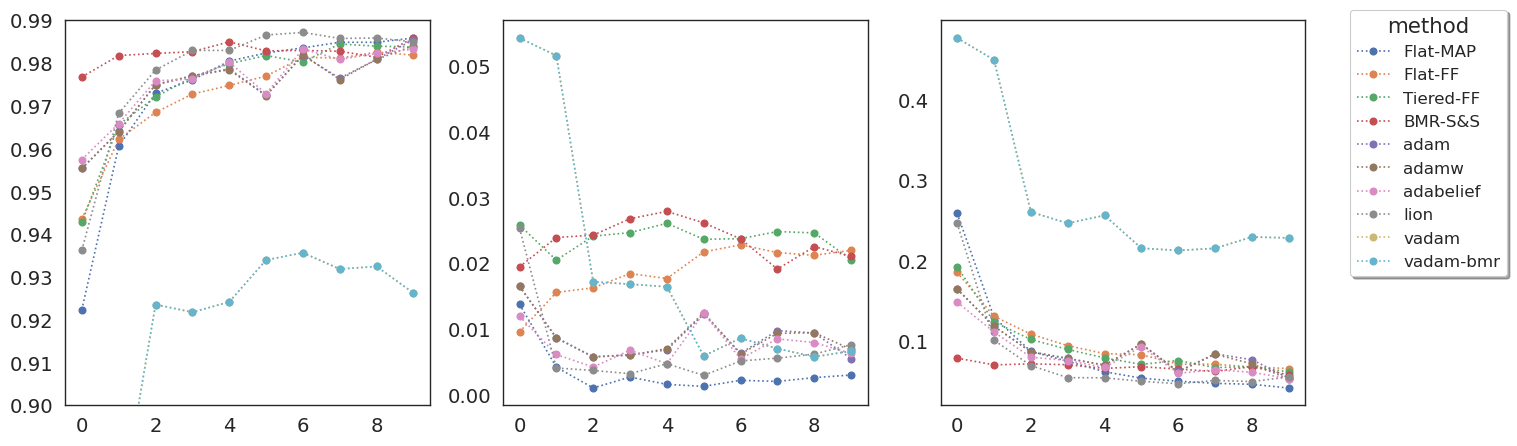

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for method in results['lenet']:
    axes[0].plot(results['lenet'][method]['acc'], 'o:')
    axes[1].plot(results['lenet'][method]['ece'], 'o:')
    axes[2].plot(results['lenet'][method]['nll'], 'o:', label=method)

for method in results_all:
    axes[0].plot(results_all[method][0]['acc'], 'o:')
    axes[1].plot(results_all[method][0]['ece'], 'o:')
    axes[2].plot(results_all[method][0]['nll'], 'o:', label=method)


axes[-1].legend(bbox_to_anchor=(1.1, 1.05), fancybox=True, shadow=True, title='method', fontsize=12)
axes[0].set_ylim([.9, .99]);

In [66]:
#TODO: 
# 1. check out the alternative algorithms and try implementing them.
# Particularly, we can turn precision update into unconstrained optimization 
# and used BBVI for updating.
# https://arxiv.org/pdf/1906.02506.pdf
# https://arxiv.org/pdf/2107.04562.pdf
# https://proceedings.mlr.press/v80/khan18a/khan18a.pdf

# 2. write completly custom training-loss functionality without dependence on numpyro 
# and implement optimization algorithms in optax syntax.